In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Keras imports
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import EfficientNetB7
from keras.callbacks import ReduceLROnPlateau
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Updated ImageDataGenerator import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Sklearn imports
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# General imports
import random
import keras

import shutil



2024-12-21 17:36:28.815470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-21 17:36:28.815582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-21 17:36:28.984648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Class counts: [239, 4522, 867, 3323, 2624, 12875, 253, 628]


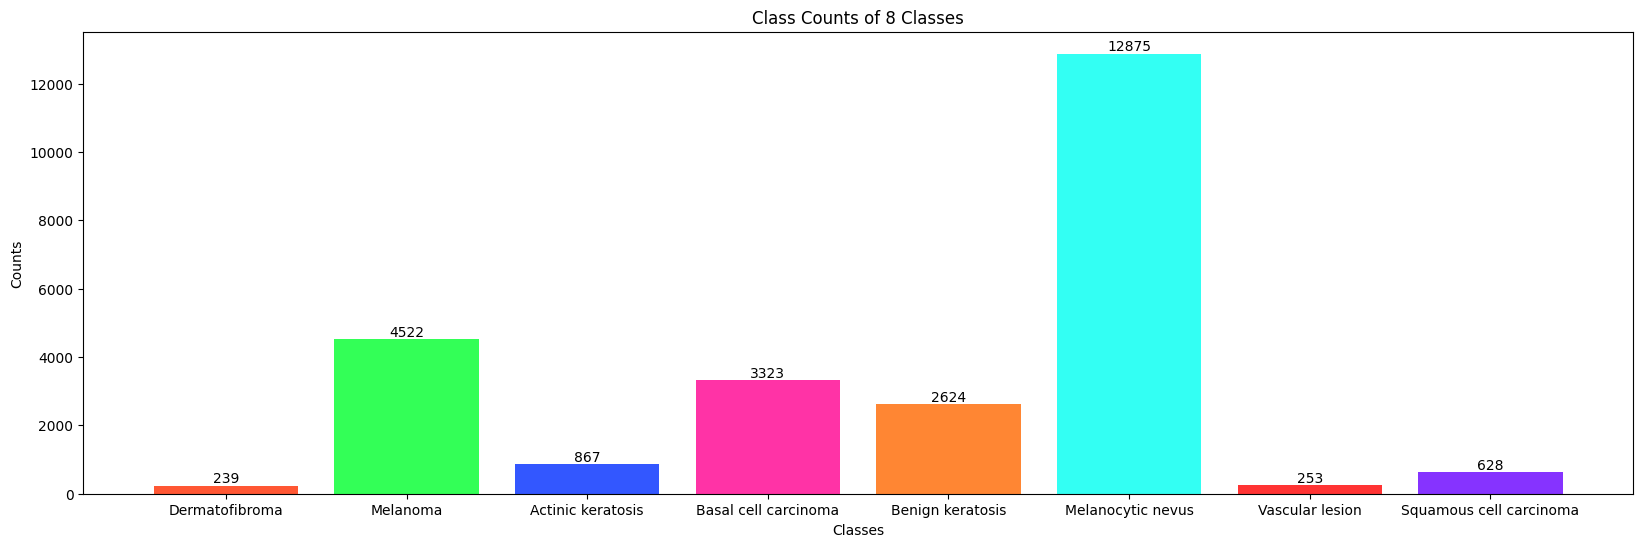

In [2]:
''' Block to visualize class frequencies before oversampling and undersampling '''

# Define paths
data_path = '/kaggle/input/isic-skin-disease-image-dataset-labelled/ISIC_Labelled'
output_path = '/kaggle/working/ISIC_Labelled'


# Remove the existing dataset from the working directory if it exists
if os.path.exists(output_path):
    shutil.rmtree(output_path)

# Copy the dataset to a writable directory
if not os.path.exists(output_path):
    shutil.copytree(data_path, output_path)



# Use the copied dataset
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(20, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6', 
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()





# Issue of class imbalance
As seen from the bar graph samples for classes like Dermatofibroma, Vascular lesion, Actinic Keratosis and Squamous cell carcinoma are less then 1000 while the remaining four classes have samples above 1000 and for Melanocytic nevus it is too high above 12000. The issue is generally called class imbalance problem which causes the training to be biased to the majority class inturn reducing accuracy of model. The issue can be solved by the following two techniques:
<ul>
<li> Undersampling </li>
<li> Oversampling </li>
</ul>
<ul>
<li> Undersampling brings down the samples of majority classes by just trimming out the datasets. Disadvantage: Information lost can lead to underfitting. </li>
<li> Oversampling increases samples by replicating images available in many ways. Disavantage: It can lead to overfitting over same sample if not done correctly </li>
</ul>
For this dataset either oversampling or undersampling alone will not work as the huge difference between the counts will either bring overfitting or underfitting problem. Combination of both the techniques is to be used. 
<p> First oversampler is used for all the 7 classes to increase the count to 5000. The oversampler function is coded to use rndom image from the available images every time till the required count is achieved. Random image is chosen so as to prevent overfitting on single image duplicates. </p>

In [3]:
from PIL import Image
import numpy as np

# Oversampler function
def oversampler(class_name, class_count, target=4000, batch_size=32, target_size=(240, 240)):
    # Initialize the ImageDataGenerator with augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    curr_dir = os.path.join(output_path, class_name)
    save_dir = curr_dir

    # Load images from the current class folder
    images = os.listdir(curr_dir)
    images = [os.path.join(curr_dir, img) for img in images]

    cnt = class_count
    target = target
    
    # Loop over images in batches, apply augmentation, and save them
    while cnt < target:
        batch_images = []
        
        # Load and resize images to the target size before converting to NumPy array
        for img_path in random.sample(images, batch_size):
            img = Image.open(img_path)
            img = img.resize(target_size)  # Resize the image
            img = np.array(img)  # Convert the PIL image to a NumPy array
            batch_images.append(img)

        batch_images = np.array(batch_images)  # Convert the list of images to a NumPy array

        # Process and augment the batch of images
        for _ in datagen.flow(batch_images, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            cnt += batch_size
            if cnt >= target:
                break
        
        print(f"Processed {cnt}/{target} images for {class_name}")

# Undersampler function
def undersampler(class_name, class_count, target_count=4000):
    curr_dir = os.path.join(output_path, class_name)
    images = os.listdir(curr_dir)

    # Calculate the number of images to delete
    images_to_delete = random.sample(images, class_count - target_count)

    # Delete images in batches
    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        try:
            os.remove(img_path)
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

    print(f"Deleted {len(images_to_delete)} images for {class_name}")




In [4]:
# Oversample or undersample each class
for i, class_name in enumerate(classes):
    if class_counts[i] < 4000:
        oversampler(class_name, class_counts[i])
    else:
        undersampler(class_name, class_counts[i])

print("Oversampling and undersampling completed successfully.")

Processed 4015/4000 images for Dermatofibroma
Deleted 522 images for Melanoma
Processed 4003/4000 images for Actinic keratosis
Processed 4027/4000 images for Basal cell carcinoma
Processed 4000/4000 images for Benign keratosis
Deleted 8875 images for Melanocytic nevus
Processed 4029/4000 images for Vascular lesion
Processed 4020/4000 images for Squamous cell carcinoma
Oversampling and undersampling completed successfully.


Class counts: [3993, 4000, 3992, 4025, 3997, 4000, 4007, 4001]


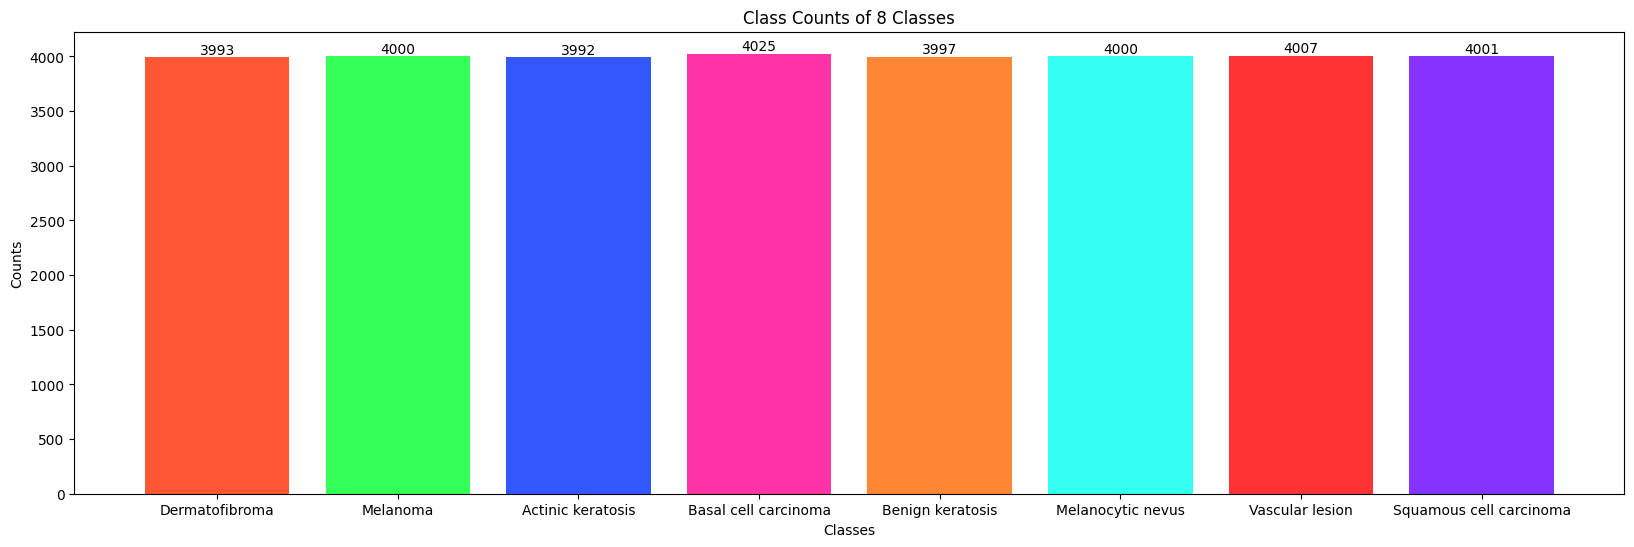

In [5]:
# Use the copied dataset
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(20, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6', 
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

In [6]:
import os
import random
import shutil

# Define paths for training, validation, and testing datasets
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

# Create directories for each dataset split
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the split ratios for train, validation, and test datasets
train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Loop over each class in the output dataset and split it
for class_folder in os.listdir(output_path):  # using the output_path where dataset resides
    class_path = os.path.join(output_path, class_folder)
    
    # Create class directories in train, val, and test folders
    train_class_path = os.path.join(train_path, class_folder)
    val_class_path = os.path.join(val_path, class_folder)
    test_class_path = os.path.join(test_path, class_folder)
    
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)
    
    # List and shuffle the images in the current class folder
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)
    
    # Split the images based on the defined ratios
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val
    
    # Allocate images to each split
    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]
    
    # Copy images to the appropriate directories
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))
    
    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))
    
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Dataset split completed successfully.")


Dataset split completed successfully.


In [9]:
""""
import zipfile

def zip_folder(folder_path, zip_name):
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Zip the datasets
zip_folder(train_path, '/kaggle/working/train_split.zip')
zip_folder(val_path, '/kaggle/working/val_split.zip')
zip_folder(test_path, '/kaggle/working/test_split.zip')

print("Datasets zipped successfully.")
"""

import os

# Paths to the ZIP files
zip_files = [
    '/kaggle/working/train_split.zip',
    '/kaggle/working/val_split.zip',
    '/kaggle/working/test_split.zip'
]

# Loop through and remove each ZIP file
for zip_file in zip_files:
    if os.path.exists(zip_file):
        os.remove(zip_file)
        print(f"Deleted: {zip_file}")
    else:
        print(f"File not found: {zip_file}")

File not found: /kaggle/working/train_split.zip
File not found: /kaggle/working/val_split.zip
File not found: /kaggle/working/test_split.zip


In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define image size and batch size
img_size = (256, 256)
batch_size = 32

# Paths to train and validation datasets (as defined in the previous steps)
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

# Create the train dataset
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=123
)

# Get the class names from the training dataset
class_names = train_dataset.class_names

# Create the validation dataset
val_dataset = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

# Display class names (optional)
print("Class Names:", class_names)


Found 22407 files belonging to 8 classes.
Found 4799 files belonging to 8 classes.
Class Names: ['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']


(32, 256, 256, 3)
[3 2 0 0 3 5 7 3 4 6 7 2 5 5 4 4 4 4 3 6 4 1 4 0 4 5 2 7 4 4 7 6]


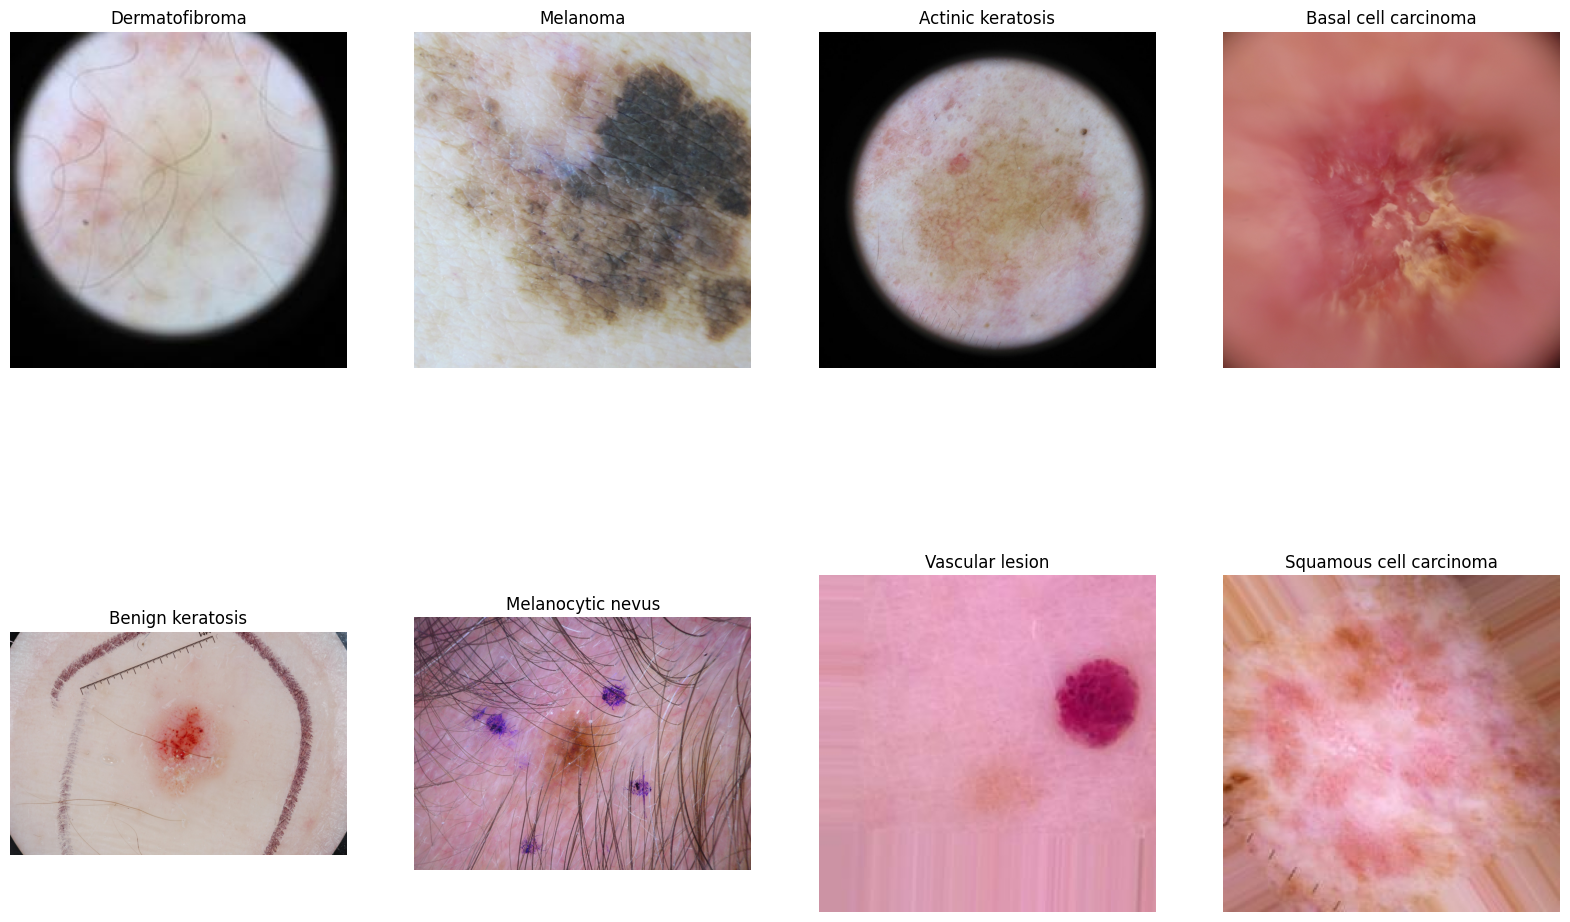

In [11]:

import matplotlib.pyplot as plt
from PIL import Image
import os

# Displaying a batch of images and labels from the train dataset
for image_batch, labels_batch in train_dataset.take(1):  # Take the first batch from the train dataset
    print(image_batch.shape)  # Print the shape of the image batch (should be [batch_size, img_size[0], img_size[1], 3])
    print(labels_batch.numpy())  # Print the corresponding labels of the images

# Visualizing images from the first few classes in the training dataset
plt.figure(figsize=(20, 20))
i = 0
for image_class in os.listdir(train_path):
    class_path = os.path.join(train_path, image_class)
    image_file = os.listdir(class_path)[0]  # Get the first image from each class
    image_path = os.path.join(class_path, image_file)
    image = Image.open(image_path)
    
    # Display the image in a grid
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    plt.title(image_class)
    plt.axis("off")  # Hide axes for a cleaner image display
    i += 1

plt.show()


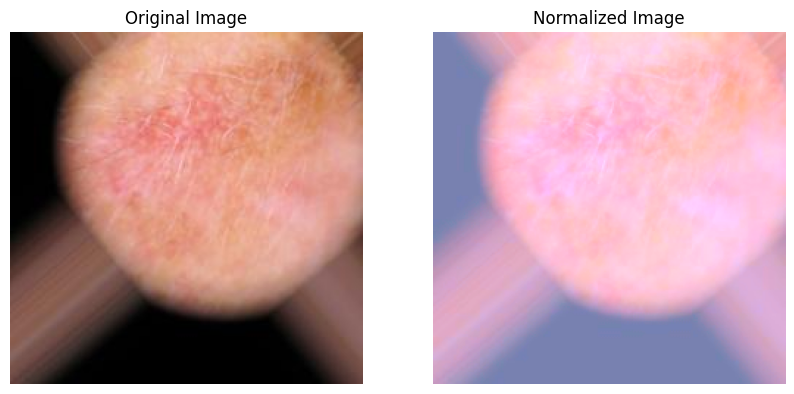

In [11]:
"""
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def stain_normalization(image, target_mean=np.array([196, 154, 122]), target_std=np.array([33, 11, 13])):
    # Convert image to LAB color space
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Compute mean and standard deviation of each channel
    image_mean = np.mean(image_lab, axis=(0, 1))
    image_std = np.std(image_lab, axis=(0, 1))
    
    # Perform stain normalization
    image_lab[:, :, 0] = (image_lab[:, :, 0] - image_mean[0]) * (target_std[0] / image_std[0]) + target_mean[0]
    image_lab[:, :, 1] = (image_lab[:, :, 1] - image_mean[1]) * (target_std[1] / image_std[1]) + target_mean[1]
    image_lab[:, :, 2] = (image_lab[:, :, 2] - image_mean[2]) * (target_std[2] / image_std[2]) + target_mean[2]
    
    # Convert back to RGB color space
    normalized_image = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    
    return normalized_image

# Example usage - Adjusting the path to load an image from the train dataset directory
train_path = '/kaggle/working/train'
class_name = 'Actinic keratosis'  # Use any class from your dataset
class_path = os.path.join(train_path, class_name)

# Load the first image from the selected class
image_file = os.listdir(class_path)[0]
image_path = os.path.join(class_path, image_file)
input_image = plt.imread(image_path)

# Apply stain normalization
normalized_image = stain_normalization(input_image)

# Display original and normalized images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Original Image')
plt.axis('off')

# Normalized Image
plt.subplot(1, 2, 2)
plt.imshow(normalized_image)
plt.title('Normalized Image')
plt.axis('off')

plt.show()
"""

In [18]:
# Preprocessing function
@tf.function
def preprocess_image(image, label):
    # Resize the image
    image = tf.image.resize(image, [256, 256])
    # Apply EfficientNet preprocessing
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# Apply the preprocessing pipeline to the datasets
train_dataset = train_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

In [19]:
from keras.applications.efficientnet import preprocess_input


# Feature extractor
base_model = keras.applications.EfficientNetB3(
    input_shape=(256, 256, 3), 
    include_top=False,             
    weights='imagenet',
    pooling='max'
) 

for layer in base_model.layers:
    layer.trainable = False

# Build model
inputs = base_model.input
x = BatchNormalization()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(8, activation='softmax')(x) #output layer 
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        960 │ block1a_se_excit

 Total params: 13,284,407 (50.68 MB)

 Trainable params: 2,497,800 (9.53 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [21]:
# Train the model
epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)


Epoch 1/50
  2/701 ━━━━━━━━━━━━━━━━━━━━ 1:04 92ms/step - accuracy: 0.1641 - loss: 2.3208   

I0000 00:00:1734804549.850436     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


701/701 ━━━━━━━━━━━━━━━━━━━━ 176s 170ms/step - accuracy: 0.5284 - loss: 1.2705 - val_accuracy: 0.7268 - val_loss: 0.7408
Epoch 2/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 65s 92ms/step - accuracy: 0.7134 - loss: 0.7984 - val_accuracy: 0.7385 - val_loss: 0.7187
Epoch 3/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 65s 92ms/step - accuracy: 0.7360 - loss: 0.7084 - val_accuracy: 0.7620 - val_loss: 0.6545
Epoch 4/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 65s 93ms/step - accuracy: 0.7620 - loss: 0.6570 - val_accuracy: 0.7685 - val_loss: 0.6496
Epoch 5/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 65s 92ms/step - accuracy: 0.7766 - loss: 0.6101 - val_accuracy: 0.7681 - val_loss: 0.6337
Epoch 6/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 65s 92ms/step - accuracy: 0.7887 - loss: 0.5702 - val_accuracy: 0.7825 - val_loss: 0.6087
Epoch 7/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 65s 92ms/step - accuracy: 0.8028 - loss: 0.5477 - val_accuracy: 0.7825 - val_loss: 0.6087
Epoch 8/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 65s 92ms/step - accuracy: 0.8109 - loss: 0.5197 - val_accur

Found 4809 files belonging to 8 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

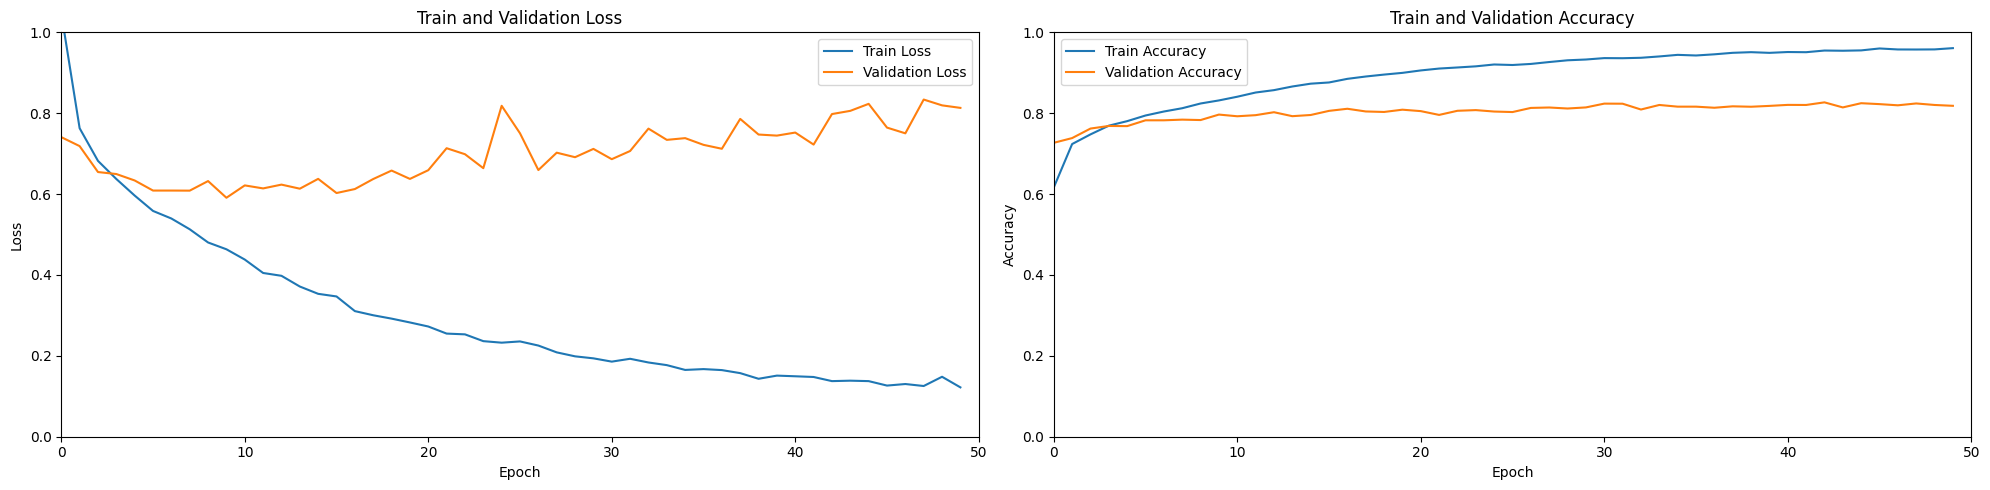

<Figure size 2000x500 with 0 Axes>

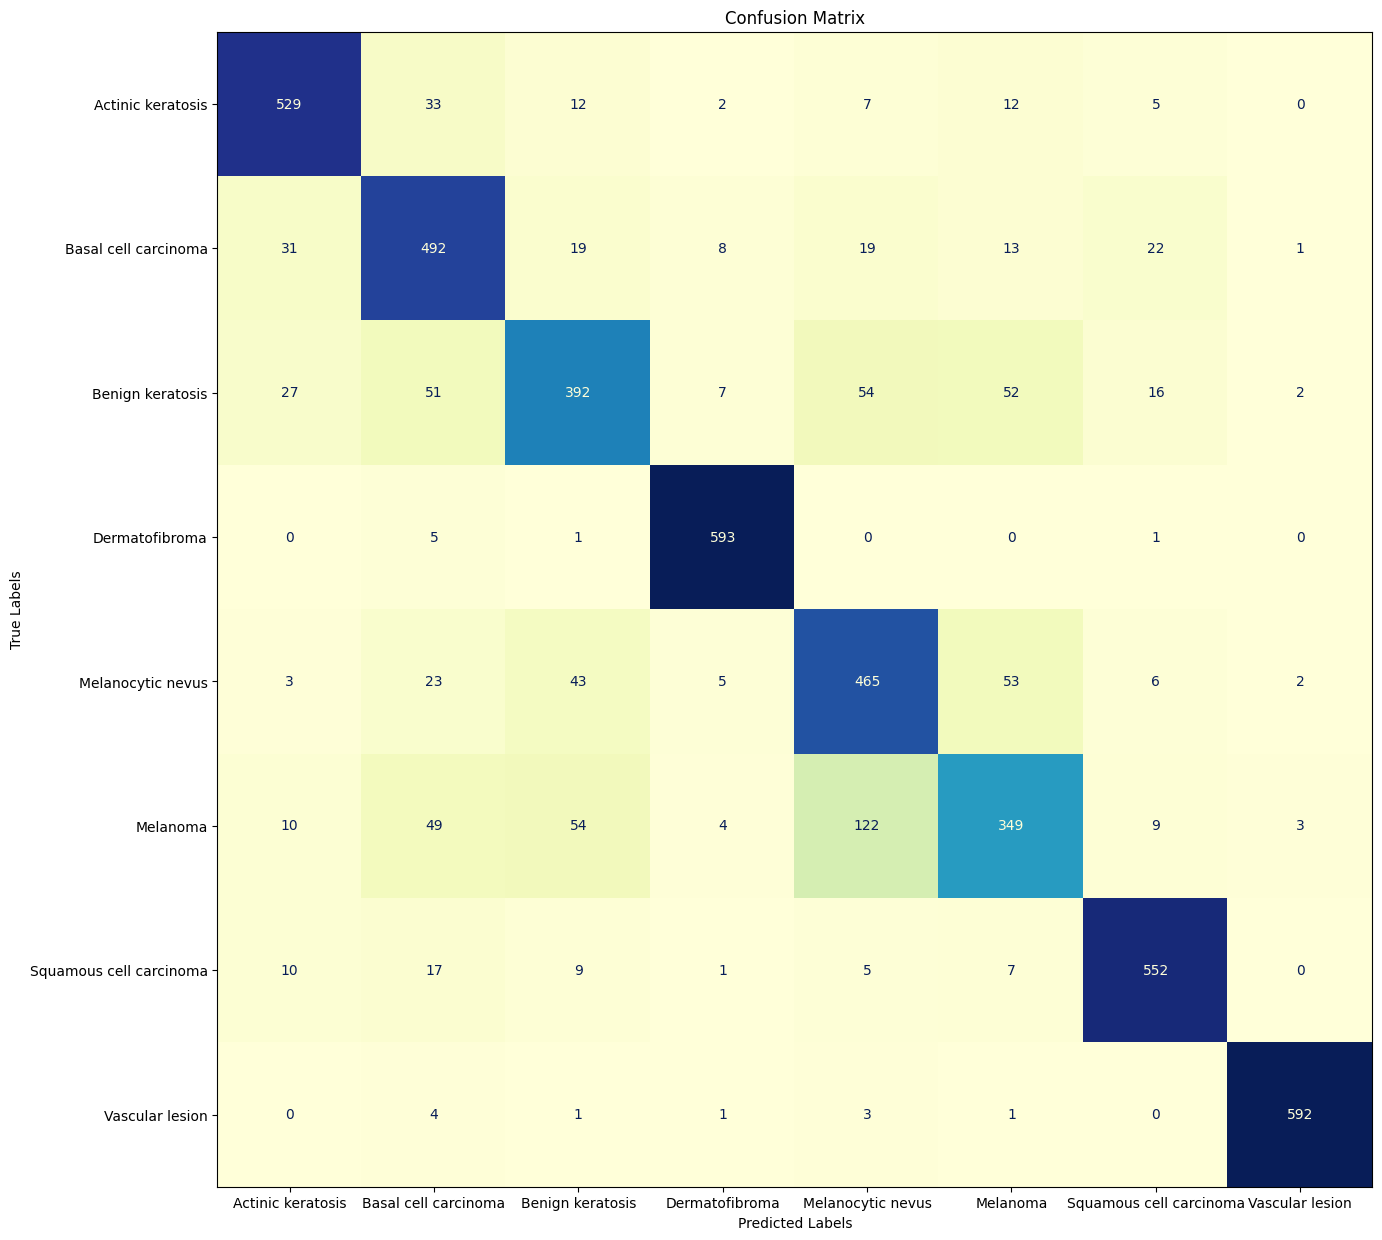

In [22]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
import sklearn
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Paths for test data
test_path = '/kaggle/working/test'

# Load test dataset
test_dataset = image_dataset_from_directory(
    test_path,
    image_size=img_size,  # Keep the same image size (256, 256)
    batch_size=batch_size,
    seed=42
)

# Apply the same preprocessing to test data
test_dataset = test_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

# Initialize lists for storing predictions and labels
labels = []
predictions = []

# Iterate through the test dataset
for x, y in test_dataset:
    labels.append(y.numpy().astype("uint8"))
    predictions.append(tf.argmax(model.predict(x), axis=1).numpy().astype("uint8"))

# Flatten the lists
labels = list(itertools.chain.from_iterable(labels))
predictions = list(itertools.chain.from_iterable(predictions))

# Print Metrics
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1] * 100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))
print('F1 score:', f1_score(labels, predictions, average='micro'))

# Plot Training and Validation Loss
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, len(history.history['accuracy']))
plt.ylim(0.0, 1.0)
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, len(history.history['accuracy']))
plt.ylim(0.0, 1.0)
plt.legend()
plt.tight_layout()

# Confusion Matrix
plt.figure(figsize=(20,5))
cm = confusion_matrix(labels, predictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # Use class_names from train dataset
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax, colorbar=False, cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
import h5py

def safe_model_save(model, filepath):
    try:
        model.save(filepath)
    except Exception as e:
        print("Error saving model:", e)
        if isinstance(e, TypeError) and 'EagerTensor' in str(e):
            print("Attempting to convert problematic tensors to numpy arrays")
            for layer in model.layers:
                if hasattr(layer, 'get_weights'):
                    weights = layer.get_weights()
                    new_weights = [w.numpy() if isinstance(w, tf.Tensor) else w for w in weights]
                    layer.set_weights(new_weights)
            model.save(filepath)

safe_model_save(model, 'SkinDiseaseWeightsPre1.h5')

In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import tensorflow as tf

test_path = 'test'

test_dataset = image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

labels = []
predictions = []
for x,y in test_dataset:
    labels.append(list(y.numpy().astype("uint8")))
    predictions.append(tf.argmax(model.predict(preprocess_input(x)),1).numpy().astype("uint8"))
import itertools
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))
print('F1 score:', f1_score(labels, predictions, average='micro'))

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.0,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
import sklearn
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(1,9)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()